In [1]:
from pyspark.sql.functions import year, udf
import matplotlib.pyplot as plt
%matplotlib inline

http://www.gbif.org/analytics/global

In [2]:
df = sqlContext.read.load("/guoda/data/idigbio-20170607T183747.parquet")

In [3]:
df.count()

104661524

In [4]:
year_summary = df.groupBy(year("datecollected").cast("integer").alias("yearcollected")).count().orderBy("yearcollected").persist()

In [5]:
year_summary.count()

1390

In [6]:
year_summary.printSchema()

root
 |-- yearcollected: integer (nullable = true)
 |-- count: long (nullable = false)



In [7]:
year_summary.describe().show()

+-------+----------------+-----------------+
|summary|   yearcollected|            count|
+-------+----------------+-----------------+
|  count|            1389|             1390|
|   mean|2316.51403887689|75296.06043165468|
| stddev| 2122.4294635612|752125.4364303288|
|    min|             100|                1|
|    max|            9999|         27146522|
+-------+----------------+-----------------+



In [8]:
year_summary.head(10)

[Row(yearcollected=None, count=27146522),
 Row(yearcollected=100, count=3),
 Row(yearcollected=102, count=1),
 Row(yearcollected=103, count=2),
 Row(yearcollected=104, count=2),
 Row(yearcollected=105, count=5),
 Row(yearcollected=106, count=9),
 Row(yearcollected=107, count=3),
 Row(yearcollected=108, count=3),
 Row(yearcollected=109, count=4)]

In [9]:
year_summary.orderBy("yearcollected", ascending=False).head(10)

[Row(yearcollected=9999, count=9187),
 Row(yearcollected=9998, count=1),
 Row(yearcollected=9983, count=1),
 Row(yearcollected=9972, count=4),
 Row(yearcollected=9960, count=1),
 Row(yearcollected=9948, count=2),
 Row(yearcollected=9863, count=1),
 Row(yearcollected=9855, count=1),
 Row(yearcollected=9840, count=2),
 Row(yearcollected=9832, count=3)]

In [10]:
pandas_year_summary = year_summary.filter(year_summary.yearcollected >= 1817).filter(year_summary.yearcollected <= 2017).orderBy("yearcollected").toPandas()

In [11]:
pandas_year_summary.head()

,yearcollected,count
0,1817,3447
1,1818,11556
2,1819,3748
3,1820,4009
4,1821,4754


<Container object of 201 artists>

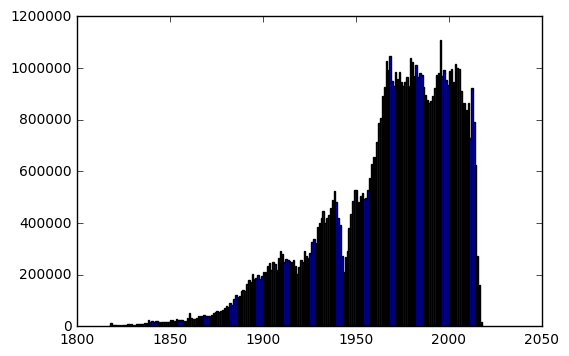

In [12]:
plt.bar(pandas_year_summary["yearcollected"], pandas_year_summary["count"])

In [25]:
yc_sum = (df
          .groupBy(year("datecollected").cast("integer").alias("yearcollected"),
                   "continent")
          .count()
          .orderBy("yearcollected")
          .persist()
          )

In [26]:
yc_sum.head(10)

[Row(yearcollected=None, continent='australia', count=1386899),
 Row(yearcollected=None, continent='indian o.', count=29),
 Row(yearcollected=None, continent='néotropique', count=384),
 Row(yearcollected=None, continent='europe, europe', count=1636),
 Row(yearcollected=None, continent='afrotropique', count=252),
 Row(yearcollected=None, continent='east indies', count=268),
 Row(yearcollected=None, continent='southern end of chagos-laccadive ridge, indian ocean.', count=19),
 Row(yearcollected=None, continent='seas of japan', count=1),
 Row(yearcollected=None, continent='australia?', count=1),
 Row(yearcollected=None, continent='samoa islands', count=8)]

We're going to have to fix some data!

In [27]:
continents = set(["africa", "asia", "australia", "europe", "north america", "south america"])
def fix_continent(c):
    if c in continents:
        return c
    else:
        return "other"
print(fix_continent("europe"))    
print(fix_continent("oceana"))

europe
other


In [28]:
fix_continent_udf = udf(fix_continent)
yc_sum = (df
          .withColumn("fixed", fix_continent_udf(df.continent))
          .groupBy(year("datecollected").cast("integer").alias("yearcollected"),
                   "fixed")
          .count()
          .orderBy("yearcollected")
          .persist()
          )

In [29]:
yc_sum.head(10)

[Row(yearcollected=None, fixed='north america', count=6661147),
 Row(yearcollected=None, fixed='europe', count=2312443),
 Row(yearcollected=None, fixed='other', count=13130500),
 Row(yearcollected=None, fixed='africa', count=802446),
 Row(yearcollected=None, fixed='asia', count=1451924),
 Row(yearcollected=None, fixed='australia', count=1386899),
 Row(yearcollected=None, fixed='south america', count=1401163),
 Row(yearcollected=100, fixed='south america', count=1),
 Row(yearcollected=100, fixed='other', count=1),
 Row(yearcollected=100, fixed='north america', count=1)]

In [30]:
yc_sum.groupBy(yc_sum.fixed).count().show()

+-------------+-----+
|        fixed|count|
+-------------+-----+
|    australia|  522|
|north america|  994|
|       europe|  546|
|south america|  513|
|        other|  779|
|       africa|  412|
|         asia|  413|
+-------------+-----+



In [31]:
yc_cross = (df
            .select(year("datecollected").cast("integer").alias("yearcollected"),
                    df.continent)
            .withColumn("fixed", fix_continent_udf(df.continent))
            .crosstab("yearcollected", "fixed")
            )

In [32]:
yc_cross.head(5)

[Row(yearcollected_fixed='892', africa=0, asia=0, australia=0, europe=0, north america=2, other=0, south america=0),
 Row(yearcollected_fixed='2199', africa=0, asia=0, australia=0, europe=0, north america=1, other=1, south america=0),
 Row(yearcollected_fixed='1665', africa=2, asia=0, australia=0, europe=1, north america=2, other=2, south america=0),
 Row(yearcollected_fixed='1036', africa=0, asia=2, australia=0, europe=0, north america=15, other=0, south america=0),
 Row(yearcollected_fixed='9131', africa=0, asia=0, australia=0, europe=0, north america=1, other=0, south america=0)]

In [33]:
pandas_yc_cross = (yc_cross
                   .filter(yc_cross.yearcollected_fixed >= 1817)
                   .filter(yc_cross.yearcollected_fixed <= 2017)
                   .orderBy(yc_cross.yearcollected_fixed)
                   .toPandas()
                   )

In [34]:
pandas_yc_cross.head(200)

,yearcollected_fixed,africa,asia,australia,europe,north america,other,south america
0,1817,76,139,385,534,471,390,1452
1,1818,43,246,477,805,5365,4259,361
2,1819,76,332,487,1066,560,914,313
3,1820,50,155,217,1741,641,997,208
4,1821,79,715,115,1853,464,876,652
5,1822,343,451,547,1241,3362,1196,325
6,1823,66,82,1441,866,371,1032,247
7,1824,319,141,124,1553,516,1181,818
8,1825,338,178,311,1246,952,1628,300
9,1826,339,120,87,1584,889,2143,1250


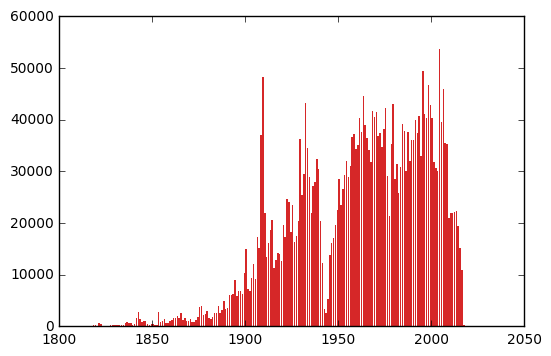

In [35]:
p1 = plt.bar(pandas_yc_cross['yearcollected_fixed'], 
                 pandas_yc_cross['asia'], color='#d62728', edgecolor='none')
#p2 = plt.bar(pandas_yc_cross['yearcollected_fixed'], 
#                 pandas_yc_cross['africa'], color='#05ff05', edgecolor='none')

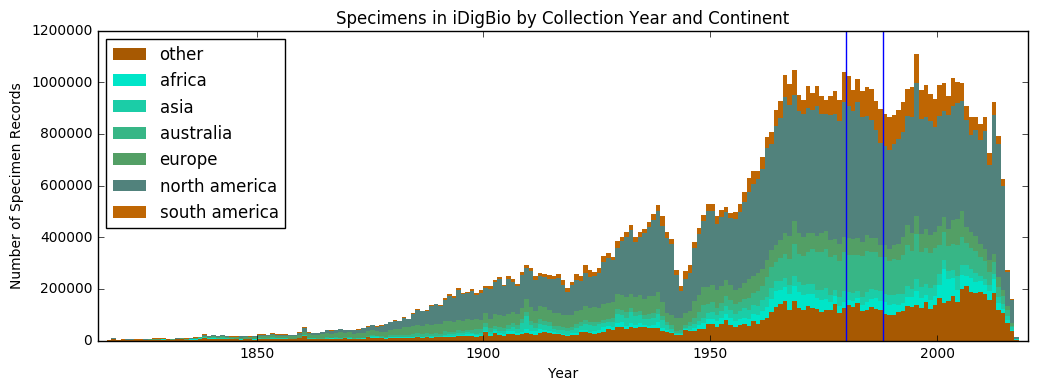

In [41]:
import pandas as pd
import numpy as np
continents_list = sorted(continents)
continents_list.insert(0, "other")
# the 100k subset has no australia stuff so graph loop fails
#continents_list.remove("australia")

# blue -> red
#colors = ["#6d6263", "#00e5c8", "#1bc4ae", "#36a395", "#51827c", "#88414a", "#a32031", "#bf0018"]

# blue -> orange
colors = ["#a75902", "#00e5c8", "#1bcda7", "#37b686", "#539f65", "#51827c", "#bf6603"]

plots = []
bottoms = pd.DataFrame(np.zeros((len(pandas_yc_cross['yearcollected_fixed']), 1)))
for c in continents_list:
    plots.append(
      plt.bar(pandas_yc_cross['yearcollected_fixed'], pandas_yc_cross[c], 
              color=colors[len(plots)], edgecolor='none',
              width=1.0, bottom=bottoms[0])
    )
    bottoms[0] += pandas_yc_cross[c]
    #print(pandas_yc_cross[c])

#print(bottoms)

plt.axvline(x=1980)
plt.axvline(x=1988)

plt.legend(plots, continents_list, loc=2)
plt.title("Specimens in iDigBio by Collection Year and Continent")
plt.ylabel("Number of Specimen Records")
plt.xlabel("Year")
axes = plt.gca()
axes.set_xlim([1815, 2020])
axes.set_ylim([0, 1200000])
fig = plt.gcf()
fig.set_size_inches(12, 4)